# PREDICTING FUTURE BEHAVIOUR OF S&P 500 STOCK MARKET INDEX
# A machine learning-based approach leveraging MarketPsych sentiment indicators


## Index
* [1. Data loading and some EDA](#1.-Data-loading-and-some-EDA)
    * [Sentiment indicators](#Sentiment-indicators)
    * [Market data](#Market-data)
* [2. Data preparation](#2.-Data-preparation)
    * [Missing values](#Missing-values)
    * [Transformations](#Transformations)
    * [Smoothing](#Smoothing)
    * [Feature Engineering](#Feature-Engineering)
        * [PCA](#PCA)
        * [Technical indicators](#Technical-indicators)
        * [New variables (crossovers)](#New-variables-(crossovers))
    * [Labeling target variable](#Labeling-target-variable)
* [3. Model](#3.-Model)

In [1]:
import mlfinlab as mlfin
import pandas as pd
import pandas_datareader as pdr
import pandas_profiling as pf
import numpy as np
from yahoo_finance import Share
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import pywt
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator, ROCIndicator
from ta.trend import MACD, ADXIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from xgboost import XGBClassifier, plot_tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.validators.scatter.marker import SymbolValidator
import ipywidgets as widgets
from ipywidgets import interact, HBox, Label
import plotly.graph_objs as go
import warnings
import sys
import os

init_notebook_mode(connected=True)

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
sns.set_context('notebook', rc={"axes.titlesize":14,"axes.labelsize":13})
sns.set_style('white')
%matplotlib inline
bbva = ['#004481','#2DCCCD', '#D8BE75','#1973B8', '#5BBEFF', '#F7893B', '#02A5A5', '#48AE64', '#F8CD51', '#F78BE8'];
sns.set_palette(bbva);
sns.color_palette(bbva)

[(0.0, 0.26666666666666666, 0.5058823529411764),
 (0.17647058823529413, 0.8, 0.803921568627451),
 (0.8470588235294118, 0.7450980392156863, 0.4588235294117647),
 (0.09803921568627451, 0.45098039215686275, 0.7215686274509804),
 (0.3568627450980392, 0.7450980392156863, 1.0),
 (0.9686274509803922, 0.5372549019607843, 0.23137254901960785),
 (0.00784313725490196, 0.6470588235294118, 0.6470588235294118),
 (0.2823529411764706, 0.6823529411764706, 0.39215686274509803),
 (0.9725490196078431, 0.803921568627451, 0.3176470588235294),
 (0.9686274509803922, 0.5450980392156862, 0.9098039215686274)]

## 1. Data loading and some EDA

### Sentiment indicators

In [2]:
def load_data(data='countries', data_type='News_Social', asset_code_id='US'):
    """
    This function loads the sentiment indicators downloaded from Thomsom Reuters, 
    i.e. the MarketPsych Sentiment Indicators related to countries, companies and currencies.
    
    Parameters
    ----------
    data: str
        One of 'countries', 'companies', 'currencies'.
    data_type: str
        Whether to filter info by data source. One of 'News', 'Social', 'News_Social'.
    asset_code_id: str
        Code of the asset / data. One of 'US', 'US500', 'USD'.
        
    Return
    ------
    Pandas dataframe.
    """
    dirs = os.listdir('./')
    if data == 'countries':
        dim, file = 'COU', 'COU_CARGA_INICIAL.csv'
        sufix = '_USA'
    elif data == 'currencies':
        dim, file = 'CUR', 'CUR_CARGA_INICIAL.csv'
        sufix = '_USD'
    elif data == 'companies':
        dim, file = 'CMPNY', 'CMPNY_GRP_CARGA_INICIAL.csv'
        sufix = '_US500'
        
    dirs = [dire_x for dire_x in os.listdir('./') if dim in dire_x]
    dataset = pd.read_csv(file, sep=';')
    dataset = dataset[dataset.date <= '2020-03-30']
    
    for dire in dirs:
        if (dire != file):
            new_month = pd.read_csv(dire, delimiter='\t')
            if len(new_month.columns) == 1:
                new_month = pd.read_csv(dire, delimiter=';')
            if 'date' not in new_month.columns:
                new_month['date'] = new_month.id.apply(lambda x: x[3:13])
            if 'asset_code_id' not in new_month.columns:
                new_month['asset_code_id'] = new_month.assetCode
            if 'data_type' not in new_month.columns:
                new_month['data_type'] = new_month.dataType
            if 'id_refinitiv' not in new_month.columns:
                new_month['id_refinitiv'] = new_month.id
            if 'system_version' not in new_month.columns:
                new_month['system_version'] = new_month.systemVersion
            if 'date_audit_laod' not in new_month.columns:
                new_month['date_audit_laod'] = 'NA'
            if 'process_audit_load' not in new_month.columns:
                new_month['process_audit_load'] = 'NA'
            new_month = new_month[dataset.columns]
            dataset = pd.concat([dataset, new_month], ignore_index=True)

    dataset = dataset[(dataset.data_type == data_type) & 
                       (dataset.asset_code_id == asset_code_id) &
                       (dataset.date >= '2000-01-01')].sort_values(by='date')
    
    dataset['Date'] = pd.to_datetime(dataset.date)
    dataset.set_index('Date', inplace=True)
    dataset.drop(['date', 'asset_code_id', 'data_type', 'id_refinitiv',
                  'system_version', 'date_audit_laod', 'process_audit_load'], axis=1, inplace=True)
    dataset.columns = [col + sufix for col in dataset.columns]
    
    return dataset

In [3]:
# Countries info
countries = load_data(data='countries', data_type='News_Social', asset_code_id='US')
#pf.ProfileReport(countries, explorative=True, minimal=True)

In [4]:
countries.describe()

,stockIndexBuzz_USA,bondBuzz_USA,ratesBuzz_USA,stockIndexSentiment_USA,stockIndexOptimism_USA,stockIndexTrust_USA,stockIndexFear_USA,stockIndexStress_USA,stockIndexSurprise_USA,stockIndexUncertainty_USA,...,bondUncertainty_USA,bondDefault_USA,bondPriceDirection_USA,bondPriceForecast_USA,bondVolatility_USA,centralBank_USA,debtDefault_USA,interestRates_USA,interestRatesForecast_USA,monetaryPolicyLooseVsTight_USA
count,7548.000000,7548.000000,7548.000000,7548.000000,7548.000000,7546.000000,7521.000000,7548.000000,7455.000000,7548.000000,...,7540.000000,7487.000000,7543.000000,7215.000000,7538.000000,7548.000000,7548.000000,7416.000000,6770.000000,7432.000000
mean,7766.818243,5018.980896,3059.338103,-0.045077,-0.004602,0.003662,0.011027,0.046969,0.004845,0.029227,...,0.020278,0.018076,0.008856,0.000788,0.028208,0.582781,0.253980,0.026239,0.007460,0.016272
std,7423.268580,5703.682036,3620.876817,0.146176,0.026762,0.005205,0.007044,0.015133,0.004011,0.027715,...,0.008642,0.012289,0.030095,0.004918,0.011702,0.131323,0.132086,0.038675,0.012789,0.031317
min,59.200000,38.000000,25.000000,-0.466583,-0.212583,-0.035411,-0.004999,0.007194,-0.009065,0.001890,...,-0.014634,-0.118110,-0.142631,-0.054225,-0.007491,0.056878,0.013831,-0.156575,-0.080899,-0.094737
25%,2221.575000,1746.250000,634.875000,-0.154254,-0.019818,0.000708,0.006011,0.036367,0.002423,0.016069,...,0.014702,0.010157,-0.006501,-0.001321,0.020393,0.498940,0.150913,0.004769,0.000681,0.000000
50%,5814.000000,3864.050000,1903.000000,-0.042142,-0.004615,0.002594,0.009419,0.044996,0.003920,0.021073,...,0.018928,0.015456,0.006400,0.000647,0.025982,0.595217,0.235606,0.015038,0.003730,0.006530
75%,11281.950000,6928.450000,4178.750000,0.066406,0.010433,0.005566,0.014252,0.055582,0.006144,0.029007,...,0.024224,0.022533,0.023477,0.002868,0.033606,0.678474,0.339387,0.036436,0.010460,0.019464
max,134839.000000,126062.900000,45542.500000,0.390025,0.231104,0.045873,0.068737,0.158899,0.072478,0.267216,...,0.098859,0.125559,0.189027,0.045312,0.153226,0.892727,0.835544,0.257800,0.103896,0.234619


In [5]:
# Currencies info
currencies = load_data(data='currencies', data_type='News_Social', asset_code_id='USD')
#pf.ProfileReport(currencies, minimal=True)

In [6]:
currencies.describe()

,buzz_USD,sentiment_USD,optimism_USD,joy_USD,loveHate_USD,trust_USD,anger_USD,conflict_USD,fear_USD,gloom_USD,...,emotionVsFact_USD,marketRisk_USD,longShort_USD,longShortForecast_USD,priceDirection_USD,priceForecast_USD,volatility_USD,carryTrade_USD,currencyPegInstability_USD,priceMomentum_USD
count,7548.000000,7547.000000,7527.000000,6838.000000,6917.000000,7462.000000,6926.000000,7526.000000,7335.000000,7481.000000,...,7548.000000,7544.000000,7459.000000,6982.000000,7545.000000,7502.000000,7471.000000,2034.000000,4162.000000,7443.000000
mean,6291.483148,-0.048832,-0.008621,0.003236,0.002251,0.002421,0.002856,0.002425,0.008548,0.021687,...,0.248426,0.035269,0.002033,0.000402,0.019455,0.000849,0.025825,0.000723,0.000541,0.005659
std,5878.626096,0.076155,0.025536,0.003636,0.003705,0.005628,0.003006,0.013154,0.006322,0.010245,...,0.068880,0.025429,0.008083,0.003613,0.045363,0.010810,0.011157,0.001348,0.002789,0.008824
min,1.000000,-0.405405,-0.238095,-0.009083,-0.031250,-0.140000,-0.005576,-0.177778,-0.044444,-0.088889,...,-0.104673,-0.154762,-0.111111,-0.111111,-0.195946,-0.120690,-0.009539,-0.000789,-0.025316,-0.060606
25%,1364.325000,-0.097635,-0.020774,0.001253,0.000934,0.000000,0.001248,-0.003665,0.004441,0.015184,...,0.207735,0.021048,-0.001442,-0.000481,-0.010270,-0.003578,0.019311,0.000121,-0.000149,0.000765
50%,4119.500000,-0.047602,-0.007243,0.002205,0.001759,0.001826,0.002090,0.001981,0.007153,0.019908,...,0.243211,0.035822,0.002030,0.000331,0.018441,0.001145,0.025046,0.000292,0.000148,0.005420
75%,10248.975000,-0.000846,0.005401,0.003954,0.002925,0.004299,0.003479,0.007852,0.011070,0.025938,...,0.281525,0.050797,0.005407,0.001226,0.047655,0.005700,0.030945,0.000736,0.000728,0.010466
max,46081.300000,0.500000,0.242424,0.061958,0.134658,0.055556,0.073132,0.208333,0.099196,0.121131,...,1.000000,0.200000,0.173913,0.133333,0.400000,0.400000,0.500000,0.018123,0.047619,0.100000


In [7]:
companies = load_data(data='companies', data_type='News_Social', asset_code_id='MPTRXUS500')
#pf.ProfileReport(companies, minimal=True)

### Market data

In [8]:
# Later on we will adapt dates to the data loaded before
start_date = datetime(1999, 11, 30)
end_date = datetime(2020, 8, 31)

# SP500 Yahoo Finance
sp500_yahoo = pdr.get_data_yahoo(symbols='^GSPC', start=start_date, end=end_date)
sp500_yahoo = sp500_yahoo.asfreq('D', method=None) # generating extra days so that we don't have date jumps
display(sp500_yahoo.head())

# Adding return and volatility just for plotting (as this has to be calculated separately in train and test)
original_columns = list(sp500_yahoo.columns)
original_columns.remove('Volume') # unrealiable volume data. It will not be used
sp500_yahoo['Daily Return'] = sp500_yahoo['Adj Close'].pct_change(periods=1)*100
sp500_yahoo['Daily Volatility'] = sp500_yahoo['Daily Return'].ewm(span=30).std() # exponential moving std
sp500_yahoo['Daily Expected Return'] = sp500_yahoo['Daily Return'].ewm(span=30).mean()

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days) + 1):
        yield start_date + timedelta(n)

weekend = [6, 7]
weekdays = []
for dt in daterange(start_date, end_date):
    if dt.isoweekday() not in weekend:
        weekdays.append(dt.strftime('%Y-%m-%d'))

# We'll take only weekdays and we'll delete weekends (as markets are closed during these days)
sp500_yahoo = sp500_yahoo[sp500_yahoo.index.isin(weekdays)]

# Expected Volatility of SP500
#vix = pdr.get_data_yahoo(symbols='^VIX', start=start_date, end=end_date)
#vix = vix.asfreq('D', method='ffill')
#display(vix.head())

# añadimos vix a sp500
#sp500['VIX Close'] = vix.Close

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-11-30,1410.589966,1386.949951,1407.829956,1388.910034,9.515000e+08,1388.910034
1999-12-01,1400.119995,1387.380005,1388.910034,1397.719971,8.840000e+08,1397.719971
1999-12-02,1409.040039,1397.719971,1397.719971,1409.040039,9.007000e+08,1409.040039
1999-12-03,1447.420044,1409.040039,1409.040039,1433.300049,1.006400e+09,1433.300049
1999-12-04,NaN,NaN,NaN,NaN,NaN,NaN


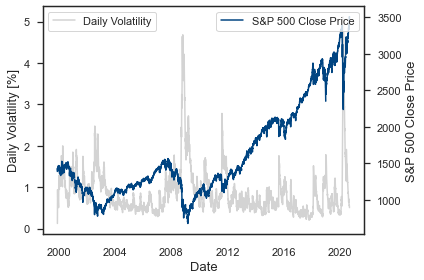

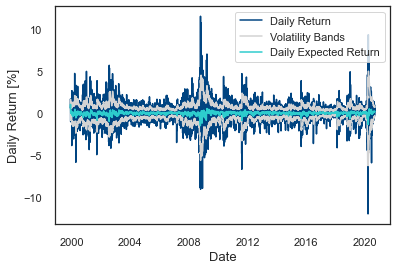

In [9]:
# Plotting price, volatility and return
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Volatility [%]')
ax1.plot(sp500_yahoo['Daily Volatility'], label='Daily Volatility', color='lightgrey')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('S&P 500 Close Price')  # we already handled the x-label with ax1
ax2.plot(sp500_yahoo['Close'], color=bbva[0], label='S&P 500 Close Price')
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

_, ax = plt.subplots()
ax.plot(sp500_yahoo['Daily Return'], color=bbva[0], label='Daily Return');
#ax.fill_between(sp500_yahoo.index, 
#                sp500_yahoo['Daily Mean Return'] + sp500_yahoo['Daily Volatility'], 
#                sp500_yahoo['Daily Mean Return'] - sp500_yahoo['Daily Volatility'],
#                color='lightgrey', label='Daily Volatility');
ax.plot(sp500_yahoo['Daily Expected Return'] + sp500_yahoo['Daily Volatility'], color='lightgrey')
ax.plot(sp500_yahoo['Daily Expected Return'] - sp500_yahoo['Daily Volatility'], color='lightgrey', label='Volatility Bands')
ax.plot(sp500_yahoo['Daily Expected Return'], color=bbva[1], label='Daily Expected Return')
ax.legend(loc='upper right')
ax.set_ylabel('Daily Return [%]');
ax.set_xlabel('Date');
#plt.xticks(rotation=30)

In [10]:
# Calculating events with cusum filter (just for plotting)
cusum_events = mlfin.filters.cusum_filter(sp500_yahoo['Adj Close'], 
                                          threshold=0.1) #threshold abs(change)

# interactive plot
warnings.filterwarnings("ignore")
#configure_plotly_browser_state()

# creating widgets
dependent=widgets.Select(options=['Close', 'Daily Return', 'Daily Volatility'],
                         value='Close', description='View', disabled=False)
dataframe=widgets.RadioButtons(options=['Companies', 'Countries', 'Currencies'], 
                               value='Companies', description='Indices', disabled=False)
sentiment1=widgets.Dropdown(options=companies.columns,
                            value='sentiment_US500', description='Comp. Value', disabled=False)
sentiment2=widgets.Dropdown(options=countries.columns,
                            value='stockIndexSentiment_USA', description='Count. Value', disabled=False)
sentiment3=widgets.Dropdown(options=currencies.columns,
                            value='sentiment_USD', description='Curr. Value',
                            disabled=False, layout={'positioning': 'right'})

# setting the ui for our widgets
ui = widgets.HBox([dependent, dataframe, widgets.VBox([sentiment1, sentiment2, sentiment3])])

#@interact
def plot_sentiment_index(dependent, dataframe, sentiment1, sentiment2, sentiment3):
    
    if dataframe == 'Companies':
        sentiment = sentiment1
        df = companies
    elif dataframe == 'Countries':
        sentiment = sentiment2
        df = countries
    elif dataframe == 'Currencies':
        sentiment = sentiment3
        df = currencies
    
    figura = make_subplots(specs=[[{"secondary_y": True}]])

    figura.add_trace(go.Scatter(y=sp500_yahoo[dependent].fillna('ffill'),
                                x=sp500_yahoo.index,
                                mode='lines',
                                name='S&P 500 '+ dependent),
                     secondary_y=True,)
    figura.add_trace(
        go.Scatter(y=df[sentiment],
                   x=df.index,
                   mode='lines',
                   name=sentiment + ' Index',
                   visible='legendonly'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=365).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 1y ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=180).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 6m ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=90).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 3m ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=30).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 1m ' + sentiment[:5] + '. Index',
                   visible='legendonly'),
                   secondary_y=False,)
    figura.add_trace(go.Scatter(y=sp500_yahoo['Adj Close'][cusum_events],
                                x=cusum_events,
                                mode='markers',
                                name='S&P 500 Index CUSUM Events'),
                     secondary_y=True,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2001-09-11'],
                   mode='markers',
                   name='Sept 11 Attacks',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2002-10-09'],
                   mode='markers',
                   name='Dot-Com Bubble Burst',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2008-09-15'],
                   mode='markers',
                   name='Lehman Brothers Collapse',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2018-12-22'],
                   mode='markers',
                   name='U.S. Federal Government Shutdown',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2020-01-20'],
                   mode='markers',
                   name='1st COVID-19 Case USA',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    """   
    # to use after results are generated
    dataset = sp500_yahoo.merge(test_labels,
                            left_index=True,
                            right_index=True,
                            how='left')
    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == 1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == 1)].index,
                   mode='markers',
                   name='Buy',
                   marker=dict(size=8, color='#008000'),
                   marker_symbol=5),
                   secondary_y=True,)
    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == -1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == -1)].index,
                   mode='markers',
                   name='Sell',
                   marker=dict(size=8, color='#FF0000'),
                   marker_symbol=6),
                   secondary_y=True,)
    """

    figura.update_layout(
        title_text='S&P 500 Index vs Sentiment Indices | Indicator: {}'.format(sentiment),
        colorway = bbva)

    figura.update_xaxes(rangeslider_visible=True)
    figura.update_yaxes(title_text="<b>Sentiment Index</b>", secondary_y=False)
    figura.update_yaxes(title_text="<b>S&P 500 Close Price</b>", secondary_y=True)

    figura.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            dict(font = dict(color = "black")),
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all"),
            ])
        )
    )

    figura.update_layout(template='simple_white', hovermode='x')
    iplot(figura)
    
out = widgets.interactive_output(plot_sentiment_index, {'dependent': dependent, 'dataframe': dataframe, 
                                                        'sentiment1': sentiment1, 'sentiment2': sentiment2,
                                                        'sentiment3': sentiment3})
display(ui, out)

Output()

## 2. Data preparation

In [11]:
# We'll only take the original columns (remember that we created three new ones just for plotting)
sp500_yahoo = sp500_yahoo[original_columns]

In [12]:
# Merging the datasets
sentiments = companies.merge(currencies.merge(countries, 
                                              left_index=True, right_index=True), left_index=True, right_index=True)
sentiments.drop_duplicates(inplace=True)
sentiments.head()

,buzz_US500,sentiment_US500,optimism_US500,joy_US500,loveHate_US500,trust_US500,anger_US500,conflict_US500,fear_US500,gloom_US500,...,bondUncertainty_USA,bondDefault_USA,bondPriceDirection_USA,bondPriceForecast_USA,bondVolatility_USA,centralBank_USA,debtDefault_USA,interestRates_USA,interestRatesForecast_USA,monetaryPolicyLooseVsTight_USA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,33223.8,0.023402,0.016494,0.023959,0.009060,0.001211,0.011212,0.011513,0.006727,0.027932,...,0.006748,NaN,-0.053981,0.026991,0.014845,0.677966,0.220339,0.016949,NaN,NaN
2000-01-02,36635.9,0.008134,0.014508,0.015217,0.010864,0.000583,0.010099,0.015354,0.007206,0.027487,...,0.023474,NaN,-0.014085,NaN,0.028169,0.840909,0.102273,0.005682,0.011364,0.005682
2000-01-03,57064.8,0.017612,0.014641,0.016096,0.008429,0.000771,0.010471,0.014816,0.006983,0.032209,...,0.009392,0.000648,-0.089708,-0.010687,0.069564,0.779070,0.085271,0.042636,0.011628,-0.011628
2000-01-04,79355.1,0.000825,0.006994,0.015147,0.009514,0.001709,0.010907,0.012847,0.007145,0.032575,...,0.006594,0.004396,-0.023380,-0.001998,0.078094,0.702671,0.118467,0.118467,0.015099,-0.004646
2000-01-05,91858.2,-0.013466,0.001110,0.014114,0.008225,0.000631,0.010941,0.011757,0.007327,0.031995,...,0.007030,0.003409,0.008308,-0.001278,0.060716,0.735938,0.115625,0.095312,0.010156,-0.007813


In [13]:
# We'll calculate a weighted average on Mondays adding info from the weekend
mondays_weekends = []
for dt in daterange(start_date, end_date):
    if dt.isoweekday() in [1, 6, 7]:
        mondays_weekends.append(dt.strftime('%Y-%m-%d'))

senti_mon = sentiments.reindex(pd.DatetimeIndex(mondays_weekends))

In [14]:
# First day was Saturday (this will be useful for allocating weights)
senti_mon.index[0]

Timestamp('1999-12-04 00:00:00')

In [15]:
# Continuation:
for col in senti_mon.columns:
    senti_mon[col] = \
        senti_mon[col].rolling(3).apply(lambda x: np.average(x, weights=[0.12, 0.22, 0.66])) 
        # damos mayor peso a los lunes (mon 2/3, sun 2/9, sat 1/9)
        
# Substituting indices corresponding to senti_mon
sentiments[sentiments.index.isin(mondays_weekends)] = senti_mon

del senti_mon

# Deleting weekends
sentiments = sentiments[sentiments.index.isin(weekdays)]
sentiments.head()

,buzz_US500,sentiment_US500,optimism_US500,joy_US500,loveHate_US500,trust_US500,anger_US500,conflict_US500,fear_US500,gloom_US500,...,bondUncertainty_USA,bondDefault_USA,bondPriceDirection_USA,bondPriceForecast_USA,bondVolatility_USA,centralBank_USA,debtDefault_USA,interestRates_USA,interestRatesForecast_USA,monetaryPolicyLooseVsTight_USA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49709.522,0.016222,0.014834,0.016846,0.009040,0.000782,0.010478,0.014538,0.007001,0.030657,...,0.012173,NaN,-0.068784,NaN,0.053891,0.780542,0.105220,0.031424,NaN,NaN
2000-01-04,79355.100,0.000825,0.006994,0.015147,0.009514,0.001709,0.010907,0.012847,0.007145,0.032575,...,0.006594,0.004396,-0.023380,-0.001998,0.078094,0.702671,0.118467,0.118467,0.015099,-0.004646
2000-01-05,91858.200,-0.013466,0.001110,0.014114,0.008225,0.000631,0.010941,0.011757,0.007327,0.031995,...,0.007030,0.003409,0.008308,-0.001278,0.060716,0.735938,0.115625,0.095312,0.010156,-0.007813
2000-01-06,105962.800,-0.003497,0.005271,0.015430,0.007866,0.001687,0.011820,0.012259,0.006304,0.028685,...,0.010203,0.003601,0.062421,0.003601,0.063502,0.694239,0.134417,0.050222,0.020679,0.000000
2000-01-07,122253.000,-0.007431,0.004474,0.015607,0.008642,0.001127,0.010294,0.010519,0.007210,0.032101,...,0.015878,0.001732,0.016455,0.002598,0.059469,0.765446,0.094966,0.068650,0.019451,0.000000


### Selecting train and test periods

In [16]:
# Splitting into train and test sets

train_start, train_end = '2001-08-31', '2016-08-31'
test_start, test_end = '2016-09-01', '2020-08-31'

sentiments_test = sentiments[test_start:test_end]
sentiments_train = sentiments[train_start:train_end]
sp500_test = sp500_yahoo[test_start:test_end]
sp500_train = sp500_yahoo[train_start:train_end]

In [17]:
# Train and test ratios
print("{0:.0%}".format(len(sp500_train)/len(sp500_yahoo[train_start:])))
print("{0:.0%}".format(len(sp500_test)/len(sp500_yahoo[train_start:])))

79%
21%


### Missing values

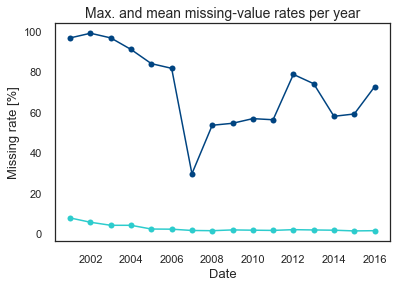

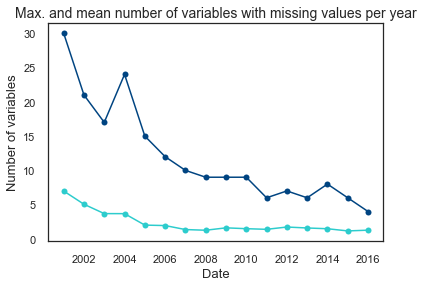

In [18]:
# We'll plot the rate of variables with missing values over time
sentiments_train['year'] = sentiments_train.index.year
sentiments_train['missing'] = sentiments_train.isnull().sum(axis=1)

((1-(sentiments_train.groupby('year').count().min(axis=1)/
    sentiments_train.groupby('year').count()['bondBuzz_USA']))*100).plot(legend=False, marker='o');
((1-(sentiments_train.groupby('year').count().mean(axis=1)/
    sentiments_train.groupby('year').count()['bondBuzz_USA']))*100).plot(legend=False, marker='o');
plt.title('Max. and mean missing-value rates per year');
plt.ylabel('Missing rate [%]');
plt.xlabel('Date');

plt.figure()
plt.plot(sentiments_train.groupby('year').max().index, 
         list(sentiments_train.groupby('year').max()['missing']), marker='o');
plt.plot(sentiments_train.groupby('year').mean().index, 
         list(sentiments_train.groupby('year').mean()['missing']), marker='o');
plt.title('Max. and mean number of variables with missing values per year');
plt.ylabel('Number of variables');
plt.xlabel('Date');

sentiments_train.drop(['year', 'missing'], axis=1, inplace=True)

# y axis represents the percentage of variables with missing values for every year 
# disclaimer: these are not missing value rates, see section Data Loading for checking those

In [19]:
# Dropping cols with a missing rate larger than 20%
missing_rate = (sentiments_train.isnull().sum() / len(sentiments_train))*100
drop_cols = [col for col in missing_rate.index if missing_rate[col] >= 20]
print(drop_cols)
sentiments_train.drop(drop_cols, axis=1, inplace=True)
sentiments_test.drop(drop_cols, axis=1, inplace=True)

['carryTrade_USD', 'currencyPegInstability_USD']


In [20]:
# Imputing missing values for the rest of variables
# We'll perform a forward filling since we're dealing with news

sentiments_train.fillna(method='ffill', inplace=True) 
sentiments_test.fillna(method='ffill', inplace=True) 

In [21]:
#msno.matrix(sp500_yahoo[['Close']])

# We'll interpolate over the days were there is no data (be it due to the closing of markets in festive days or
# just because of an absence of data due to system errors)

sp500_train.interpolate(method='spline', order=3, limit_direction='forward', 
                        axis=0, inplace=True) 
sp500_test.interpolate(method='spline', order=3, limit_direction='forward', 
                        axis=0, inplace=True) 

### Transformations

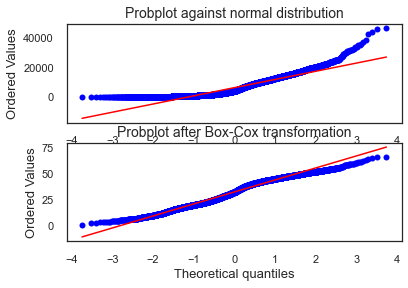

Lambda:  0.2749559707497384


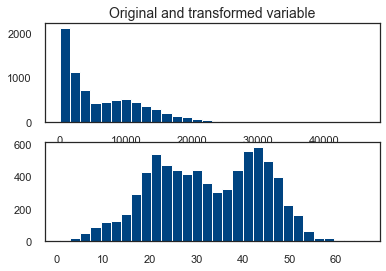

In [22]:
# We'll apply yeo johnson to balance dispersion amongst varaibles
# in this chunk we'll only apply it to the sentiments dataset. Later on we'll apply it to the financial variables
#example
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = currencies.buzz_USD
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, l = stats.yeojohnson(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()
print('Lambda: ', l)

fig, ax = plt.subplots(2,1)
ax[0].hist(x, bins=30);
ax[1].hist(xt, bins=30);
ax[0].set_title('Original and transformed variable');

In [23]:
# We use the same lambdas for test dataset

def apply_transformation(data_train, data_test, transformation):
    """
    Applies dispersion and scale transformations on data split in train and test.
    
    Parameters
    ----------
    data_train: pandas dataframe
        Train set.
    data_test: pandas dataframe
        Test set.
    transformation: str
        One of 'dispersion', 'scale' or 'dispersion_and_scale'.
        
    Returns
    -------
    Tuple with train set and test set.
    """ 
    
    data_train = data_train.dropna()
    data_test = data_test.dropna()
    
    index_train = data_train.index
    index_test = data_test.index
    
    if transformation == 'dispersion':
        for col in data_train.columns:
            data_train[col], fitted_lambda = stats.yeojohnson(data_train[col])
            data_test[col] = stats.yeojohnson(data_test[col], fitted_lambda)
            
    elif transformation == 'scale':
        scaler = StandardScaler().fit(data_train)
        std_train = scaler.transform(data_train)
        std_test = scaler.transform(data_test)
        data_train = pd.DataFrame(std_train, columns=data_train.columns)
        data_test = pd.DataFrame(std_test, columns=data_test.columns)
        data_train['Date'] = index_train
        data_test['Date'] = index_test
        data_train.set_index('Date', inplace=True)
        data_test.set_index('Date', inplace=True)
        
    elif transformation == 'dispersion_and_scale':
        for col in data_train.columns:
            data_train[col], fitted_lambda = stats.yeojohnson(data_train[col])
            data_test[col] = stats.yeojohnson(data_test[col], fitted_lambda)
        scaler = StandardScaler().fit(data_train)
        std_train = scaler.transform(data_train)
        std_test = scaler.transform(data_test)
        data_train = pd.DataFrame(std_train, columns=data_train.columns)
        data_test = pd.DataFrame(std_test, columns=data_test.columns)
        data_train['Date'] = index_train
        data_test['Date'] = index_test
        data_train.set_index('Date', inplace=True)
        data_test.set_index('Date', inplace=True)
    
    return data_train, data_test

In [24]:
# checking linear correlation before transformation
sentiments_train.optimism_US500.ewm(90).mean().corr(sp500_yahoo.Close, method='pearson')

0.904373699855421

In [25]:
# We'll also apply standardization to even scales. This will make distributions more comparable
sentiments_train, sentiments_test = apply_transformation(sentiments_train, sentiments_test, 'dispersion_and_scale')

display(sentiments_train.describe())

,buzz_US500,sentiment_US500,optimism_US500,joy_US500,loveHate_US500,trust_US500,anger_US500,conflict_US500,fear_US500,gloom_US500,...,bondUncertainty_USA,bondDefault_USA,bondPriceDirection_USA,bondPriceForecast_USA,bondVolatility_USA,centralBank_USA,debtDefault_USA,interestRates_USA,interestRatesForecast_USA,monetaryPolicyLooseVsTight_USA
count,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,...,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03
mean,6.803878e-16,-4.974424e-16,-5.251554e-17,-1.275252e-15,2.198156e-16,-4.195280e-17,1.171271e-15,9.881269e-18,1.374348e-15,6.720399e-16,...,-3.112884e-16,4.515002e-16,-2.040851e-19,1.891070e-17,6.554291e-16,-1.608120e-16,1.097218e-15,2.304494e-16,5.224579e-18,-3.448790e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,...,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-3.064271e+00,-3.836744e+00,-4.284522e+00,-3.013036e+00,-4.381088e+00,-6.928434e+00,-2.586858e+00,-4.609965e+00,-3.552208e+00,-2.670639e+00,...,-3.163638e+00,-8.062726e+00,-6.847632e+00,-6.703713e+00,-4.173702e+00,-3.048743e+00,-2.270924e+00,-9.733690e+00,-1.687397e+01,-9.594321e+00
25%,-8.493998e-01,-6.976976e-01,-6.582821e-01,-7.451503e-01,-6.698294e-01,-6.259648e-01,-7.581757e-01,-6.460022e-01,-6.559033e-01,-7.677362e-01,...,-6.686969e-01,-6.951505e-01,-4.799653e-01,-4.732337e-01,-7.013733e-01,-6.927469e-01,-7.495620e-01,-5.990254e-01,-4.879330e-01,-6.143743e-01
50%,3.815230e-02,-7.880494e-02,-1.911985e-02,-7.581875e-02,2.395684e-03,-3.272897e-02,-8.365807e-02,1.615158e-02,1.833695e-02,-2.910251e-02,...,-6.556898e-03,-4.066074e-02,-4.698007e-02,-5.073219e-02,-3.039403e-02,4.215866e-03,4.375376e-03,-1.634409e-01,-2.458350e-01,-2.346027e-01
75%,7.401832e-01,7.451540e-01,6.455215e-01,7.962038e-01,6.810202e-01,5.983299e-01,8.139464e-01,6.483610e-01,6.645912e-01,7.996133e-01,...,6.920137e-01,6.463170e-01,5.109784e-01,4.678733e-01,7.241609e-01,6.946301e-01,7.372704e-01,4.860234e-01,2.338346e-01,6.134070e-01
max,2.942192e+00,3.112603e+00,3.886110e+00,3.362441e+00,4.069919e+00,5.643069e+00,2.700716e+00,4.335172e+00,3.704308e+00,3.576385e+00,...,3.779286e+00,2.888767e+00,4.780882e+00,5.367399e+00,2.825161e+00,2.955895e+00,3.014466e+00,2.787403e+00,5.097762e+00,2.267225e+00


In [26]:
# checking linear correlation after transformation
sentiments_train.optimism_US500.ewm(90).mean().corr(sp500_yahoo.Close, method='pearson') 
# correlation has improved a little

0.9131197876553399

### Smoothing

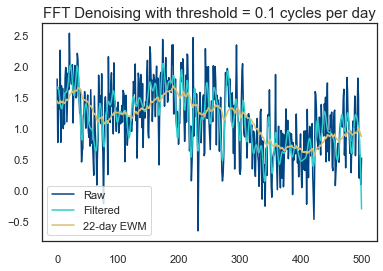

In [27]:
# testing fast fourier transform
def filter_signal(signal, threshold=1e8):
    """
    Performs a Fast Fourier Transform over a signal and returns filtered data.
    
    Parameters
    ----------
    signal: numpy array
    threshold: double
    """
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=1.)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)

span = 500
signal = np.array(sentiments_train.sentiment_US500[1:])
threshold = 0.1
filtered = filter_signal(signal, threshold=threshold)
#plt.figure(figsize=(15, 10))
plt.plot(signal[-span:], label='Raw')
#plt.plot(signal[-100:], 'bo', label='Raw')
plt.plot(filtered[-span:], label='Filtered')
plt.plot(np.array(pd.Series(signal).ewm(22).mean())[-span:], label='22-day EWM')
#plt.plot(np.array(sp500_train['Adj Close'][-span:]/max(sp500_train['Adj Close'][-span:])) - 0.8,
#         label='Adj Close Price (scaled)', color='gray')
#plt.plot(filtered[-500:], 'ro', label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = {} cycles per day".format(threshold), size=15)
plt.show()

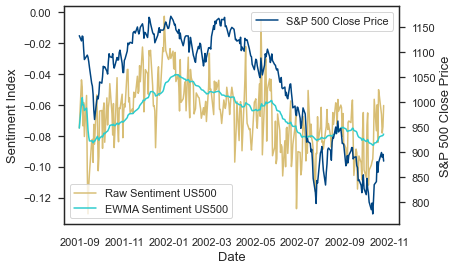

In [28]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Index')
#ax1.plot(sentiments_train['sentiment_US500'][:300], label='Transf. EWMA Sentiment US500', color=bbva[2])
ax1.plot(sentiments['sentiment_US500'][train_start:train_end][:300], label='Raw Sentiment US500', color=bbva[2])
ax1.plot(sentiments['sentiment_US500'][train_start:train_end].ewm(22).mean()[:300], label='EWMA Sentiment US500', 
         color=bbva[1])
ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('S&P 500 Close Price')  # we already handled the x-label with ax1
ax2.plot(sp500_train['Adj Close'][:300], color=bbva[0], label='S&P 500 Close Price')
ax2.legend(loc='upper right');

In [29]:
# Function for selecting smoothing technique
def select_smoothing(data, technique, span0=22):
    """
    Performs a smoothing (EWMA) or filtering (FFT) technique over data.
    
    Parameters
    ----------
    data: pandas dataframe column
    technique: str
        One of 'fft' for Fast Fourier Transform or 'ewma' for Exponentially Weighted Moving Average.
        Calls function filter_signal() for FFT.
    span0: int
        Decay in terms of span.
        
    Returns
    -------
    Pandas dataframe column.
    """
    if technique == 'fft':
        filtered = list(filter_signal(data, threshold=threshold))
        filtered.append(0)
    elif technique == 'ewma':
        filtered = data.ewm(span=span0).mean()
    return filtered

# we'll be using the ewma
for col in sentiments_train.columns:
    sentiments_train[col] = select_smoothing(sentiments_train[col], 'ewma')
    sentiments_test[col] = select_smoothing(sentiments_test[col], 'ewma')

### Feature engineering

#### PCA

In [30]:
%%capture
"""
def apply_pca(data, scale=False):
    # Separating out the features
    # already separated
    data = data.dropna()
    x = data
    
    # Standardizing the features
    if scale is True:
        x = StandardScaler().fit_transform(x) #already transformed
    pca = PCA(n_components=3)
    x_pca = pca.fit_transform(x)
    pDf = pd.DataFrame(data = x_pca, 
                       columns = ['pc1', 'pc2', 'pc3'])

    data.reset_index(inplace=True)
    data['pc1'] = pDf.pc1
    data['pc2'] = pDf.pc2
    data['pc3'] = pDf.pc3
    data.set_index('Date', inplace=True)

    print(pca.explained_variance_ratio_)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') 
    plt.title('Explained Variance')
    plt.show()

    return data

sentiments_train = apply_pca(sentiments_train, scale=False)
sentiments_test = apply_pca(sentiments_test, scale=False)"""

#### Technical indicators

[TA Library Documentation](https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html)

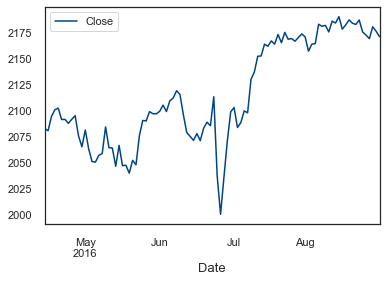

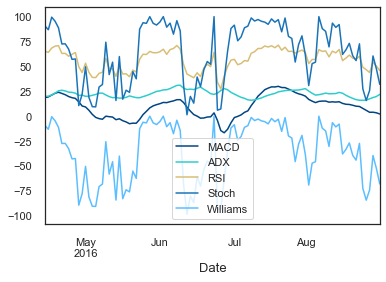

In [31]:
# We'll add some technical indicators used in trading for evaluating momemtum and trends
def add_technical_indicators(data):
    """
    Adds technical indicators widely used by traders when checking for bearish or bullish signals.
    
    Parameters
    ----------
    data: pandas dataframe
    """
    
    # data cannot contain nans before fft
    data.dropna(inplace=True)
    #d = 10 # horizonte de predicción (aquí hacia atrás)
    #fft_close = filter_signal(data['Adj Close'])
    #data['FFT Discrete Close'] = [np.sign(fft_close[i] - fft_close[i - d])
    #                              if (i - d > 0) and (i < len(fft_close)) else np.nan
    #                              for i in range(0, len(fft_close) + 1)]
    #
    data['ROC'] = ROCIndicator(data['Adj Close'], 10).roc()
    data['RSI'] = RSIIndicator(data['Adj Close'], 10).rsi()
    data['Stoch'] = StochasticOscillator(high=data['High'], 
                                         low=data['Low'], 
                                         close=data['Close'], 
                                         n=10).stoch()
    data['Williams'] = WilliamsRIndicator(high=data['High'], 
                                          low=data['Low'], 
                                          close=data['Close'],  
                                          lbp=10).wr()
    data['MACD'] = MACD(data['Close'], 
                        n_slow = 22, 
                        n_fast = 8, 
                        n_sign = 5).macd()
    data['ADX'] = ADXIndicator(high=data['High'], 
                               low=data['Low'], 
                               close=data['Close'], n=10).adx()
    
    data['Close/Open'] = [1 if data.Close[x] > data.Open[x] else 0
                          for x in range(0, len(data))]
    
    data['Daily Return'] = data['Adj Close'].pct_change(periods=1)*100
    data['Daily Volatility'] = data['Daily Return'].ewm(span=22).std() # exponential moving std
    
    ### only compute this cross if it won't later be the primary model!!
    fast_window = 20
    slow_window = 60
    col = 'Adj Close'
    data['Fast EWMA {}'.format(col)] = data[col] # already averaged
    data['Slow EWMA {}'.format(col)] = data[col].ewm(slow_window).mean()

    # Compute sides
    data['sp_cross_{}'.format(col)] = np.nan

    long_signals = data['Fast EWMA {}'.format(col)] >= data['Slow EWMA {}'.format(col)]
    short_signals = data['Fast EWMA {}'.format(col)] < data['Slow EWMA {}'.format(col)]
    data.loc[long_signals, 'sp_cross_{}'.format(col)]  = 1
    data.loc[short_signals, 'sp_cross_{}'.format(col)]  = -1

    # Lagging our trading signals by one day
    #data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

    data.drop(['Fast EWMA {}'.format(col), 'Slow EWMA {}'.format(col)], axis=1, inplace=True)

    return data

sp500_train = add_technical_indicators(sp500_train)
sp500_test = add_technical_indicators(sp500_test)

sp500_train.Close[-100:].plot(legend=True);
plt.figure()
sp500_train.MACD[-100:].plot(legend=True);
sp500_train.ADX[-100:].plot(legend=True);
sp500_train.RSI[-100:].plot(legend=True);
sp500_train.Stoch[-100:].plot(legend=True);
sp500_train.Williams[-100:].plot(legend=True);

In [32]:
# dropping close variable as it is the same as adjusted close here
#sp500_train.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
#sp500_test.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
sp500_train.drop(['Close'], axis=1, inplace=True)
sp500_test.drop(['Close'], axis=1, inplace=True)

In [33]:
# We're shifting forward the financial variables (which are related to price) since news from the
# previous day have to be used for predicting next day's prices
sp500_train = sp500_train.shift(1) 
sp500_test = sp500_test.shift(1)

In [34]:
sp500_train.head()

,High,Low,Open,Adj Close,ROC,RSI,Stoch,Williams,MACD,ADX,Close/Open,Daily Return,Daily Volatility,sp_cross_Adj Close
Date,,,,,,,,,,,,,,
2001-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-03,1141.829956,1126.380005,1129.030029,1133.579956,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0
2001-09-04,1185.417436,1146.563254,1142.752676,1123.104688,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.924087,NaN,-1.0
2001-09-05,1155.400024,1129.060059,1133.579956,1132.939941,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.875720,1.272656,1.0
2001-09-06,1135.520020,1114.859985,1132.939941,1131.739990,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.105915,0.882187,1.0


In [35]:
# Before continuing, we'll concat the financial and the sentiment datasets
X_train = pd.concat([sp500_train, sentiments_train], axis=1)
X_test = pd.concat([sp500_test, sentiments_test], axis=1)
X_train.dropna(inplace=True) # there are na values at the beginning, for the newly created variables (technical indicators)
X_test.dropna(inplace=True)

# Now we'll create y_train and y_test, our labels

#### New variables (crossovers)

In [36]:
# we'll add these ewmas as predictor or explanatory variables
def add_crossing_ewmas(data, fast_window, slow_window):
    """
    Adds two crossing exponentially weighted moving averages. 
    
    Parameters
    ----------
    data: pandas dataframe
    fast_window: int
        Fast decay in terms of span.
    slow_window: int
        Slow decay in terms of span.
        
    Returns
    -------
    Pandas dataframe.
    """

    #fast_window = 20 # 1 working month
    #slow_window = 90 # 5 working months

    for col in ['sentiment_US500', 'stockIndexSentiment_USA']:

        data['Fast EWMA {}'.format(col)] = data[col] # already averaged
        data['Slow EWMA {}'.format(col)] = data[col].ewm(slow_window).mean()

        # Compute sides
        data['cross_{}'.format(col)] = np.nan

        long_signals = data['Fast EWMA {}'.format(col)] >= data['Slow EWMA {}'.format(col)]
        short_signals = data['Fast EWMA {}'.format(col)] < data['Slow EWMA {}'.format(col)]
        data.loc[long_signals, 'cross_{}'.format(col)]  = 1
        data.loc[short_signals, 'cross_{}'.format(col)]  = -1

        # Lagging our trading signals by one day
        #data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

        data.drop(['Fast EWMA {}'.format(col), 'Slow EWMA {}'.format(col)], axis=1, inplace=True)
    
    return data

X_train = add_crossing_ewmas(X_train, 10, 60)
X_test = add_crossing_ewmas(X_test, 10, 60)

### Labeling target variable

In [37]:
# overriding function get_bins
# we want this to return the sign of the return when the vertical barrier is touched first
# instead of what it's currently implemented (0 if vertical barrier is touched first)
def get_bins(triple_barrier_events, close):
    """
    Advances in Financial Machine Learning, Snippet 3.7, page 51.

    Labeling for Side & Size with Meta Labels

    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:

    Now the possible values for labels in out['bin'] are {0,1}, whether to take the bet or pass,
    a purely binary prediction. The previous feasible values were {−1,0,1}.
    The ML algorithm will be trained to decide if it's 1, and we can use the probability of this secondary prediction
    to derive the size of the bet, where the side (sign) of the position has been set by the primary model.

    :param triple_barrier_events: (pd.DataFrame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (pd.Series) Close prices
    :return: (pd.DataFrame) Meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    all_dates = events_.index.union(other=events_['t1'].array).drop_duplicates()
    prices = close.reindex(all_dates, method='bfill')

    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    #out_df['ret'] = np.log(prices.loc[events_['t1'].array].array) - np.log(prices.loc[events_.index])
    out_df['ret'] = prices.loc[events_['t1'].values].values / prices.loc[events_.index] - 1
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    #-------------------we change this step, as we want the outcome to be the sign of the return
    #out_df = barrier_touched(out_df, triple_barrier_events) 
    out_df['bin'] = np.sign(out_df['ret'])

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0

    # Transform the log returns back to normal returns.
    #out_df['ret'] = np.exp(out_df['ret']) - 1

    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']

    return out_df


In [38]:
# Now we'll apply the labeling
def apply_trading_labeling(data, 
                           compute_side=False, 
                           horizon=14,
                           pt_sl=[1, 2], # multipliers for daily vol (contribution to horizontal barriers)
                           min_ret=0.005,
                           primary_model=False):
    """
    Applies selected trading strategy with the given parameters. Labeling uses Triple Barrier Method.

    Parameters
    __________
    dataframe: pandas dataframe 
        Data to use.
    compute_side: boolean
        Whether to use a primary model that tells the side (buy or sell).
        When True, a trend-following strategy will be applied as primary model.
        Default is False.
    horizon: int
        Prediction horizon in natural days.
    pt_sl: list
        Profit taking and stop loss multipliers to the volatility. Width of the TBM box.
    min_ret: float
        Minimum target return to run the search for triple barriers.
    primary_model: boolean
        Whether a primary model computed by the user has already decided the side.
        
    Returns
    -------
    Labels dataframe and triple-barrier events dataframe.
    """

    ####--------------------- Primary models ------------------------####
    if compute_side is True:
        # compute exponentially moving averages
        fast_window = 20
        slow_window = 90 # optimize the span for fast and slow averages

        data['Fast EWMA'] = data['Adj Close'].ewm(fast_window).mean()
        data['Slow EWMA'] = data['Adj Close'].ewm(slow_window).mean()
    
        # Compute sides
        data['Side'] = np.nan

        long_signals = data['Fast EWMA'] >= data['Slow EWMA']
        short_signals = data['Fast EWMA'] < data['Slow EWMA']
        data.loc[long_signals, 'Side'] = 1
        data.loc[short_signals, 'Side'] = -1

        # Lagging our trading signals by one day
        data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

        data[['Fast EWMA', 'Slow EWMA']].plot();
    
    data.dropna(inplace=True)

    ####--------------------- CUSUM filters ------------------------####
    # Apply Symmetric CUSUM Filter and get timestamps for events
    cusum_events = mlfin.filters.cusum_filter(data['Adj Close'],
                                              threshold=data['Daily Volatility']/100)

    ####--------------------- Vertical barriers ------------------------####
    # Compute vertical barrier
    vertical_barriers = mlfin.labeling.add_vertical_barrier(t_events=cusum_events,
                                                            close=data['Adj Close'],
                                                            num_days=horizon) # this is the length of the tbm box
    
    ####--------------------- Triple barriers ------------------------####
    # Computing triple barriers
    if (compute_side is True) | (primary_model is True):
        triple_barrier_events = mlfin.labeling.get_events(close=data['Adj Close'],
                                                       t_events=cusum_events,
                                                       pt_sl=pt_sl, # profit taking and stop loss multiples
                                                       target=data['Daily Volatility']/100, # values in conjunction with pt_sl for width of barrier
                                                       min_ret=min_ret,
                                                       num_threads=3, # num of parallel tasks
                                                       vertical_barrier_times=vertical_barriers,
                                                       side_prediction=data.Side)
        ####--------------------- Meta-labels ------------------------####
        # now we compute the meta-labelling
        meta_labeled_events = get_bins(triple_barrier_events, data['Adj Close'])
    
    else:
        triple_barrier_events = mlfin.labeling.get_events(close=data['Adj Close'],
                                                       t_events=cusum_events,
                                                       pt_sl=pt_sl, # profit taking and stop loss multiples
                                                       target=data['Daily Volatility']/100, # values in conjunction with pt_sl for width of barrier
                                                       min_ret=min_ret,
                                                       num_threads=3, # num of parallel tasks
                                                       vertical_barrier_times=vertical_barriers,
                                                       side_prediction=None)

        ####--------------------- Side ------------------------####
        # now we compute the side 
        # function that does meta-labeling returns side if no side prediction comes first
        meta_labeled_events = get_bins(triple_barrier_events, data['Adj Close'])
        meta_labeled_events['side'] = meta_labeled_events['bin']
        meta_labeled_events['bin'] = 1

    return meta_labeled_events, triple_barrier_events


In [39]:
# computing labels for side (+1, -1) 
# side will tell the sign of the bet
train_labels, tbm_train = apply_trading_labeling(X_train, 
                                     primary_model=False, 
                                     compute_side=False,
                                     horizon=14,
                                     pt_sl=[0, 0],
                                     min_ret=0.005)
test_labels, tbm_test = apply_trading_labeling(X_test, 
                                     primary_model=False, 
                                     compute_side=False,
                                     horizon=14,
                                     pt_sl=[0, 0],
                                     min_ret=0.005)

2021-11-05 19:11:32.864278 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
2021-11-05 19:11:38.634043 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..


In [40]:
display(train_labels.head())
display(tbm_train.head())

,ret,trgt,bin,side
2001-10-04,0.004486,0.017967,1,1.0
2001-10-11,0.003895,0.015892,1,1.0
2001-10-17,-0.034395,0.013810,1,-1.0
2001-10-18,-0.016071,0.014603,1,-1.0
2001-10-23,0.011873,0.013648,1,1.0


,t1,trgt,pt,sl
2001-10-04,2001-10-18,0.017967,0,0
2001-10-11,2001-10-25,0.015892,0,0
2001-10-17,2001-10-31,0.013810,0,0
2001-10-18,2001-11-01,0.014603,0,0
2001-10-23,2001-11-06,0.013648,0,0


In [41]:
# plotting labels to see outcome
#configure_plotly_browser_state()
@interact
def plot_sentiment_index(data=widgets.RadioButtons(
                            options=['Train', 'Test'],
                            value='Test',
                            # rows=10,
                            description='Data',
                            disabled=False)):

    figura = make_subplots(specs=[[{"secondary_y": False}]])
    if data == 'Test':
        dataset = X_test.merge(test_labels,
                            left_index=True,
                            right_index=True,
                            how='left')
        figura.add_trace(go.Scatter(y=X_test['Adj Close'],
                                    x=X_test.index,
                                    mode='lines',
                                    name='S&P 500 Close Price'),
                         secondary_y=False,)
    else:
        dataset = X_train.merge(train_labels,
                            left_index=True,
                            right_index=True,
                            how='left')
        figura.add_trace(go.Scatter(y=X_train['Adj Close'],
                                    x=X_train.index,
                                    mode='lines',
                                    name='SP500 Close Price'),
                         secondary_y=False,)
    if ('Fast EWMA' in dataset.columns) and ('Slow EWMA' in dataset.columns):
        figura.add_trace(go.Scatter(y=dataset['Fast EWMA'],
                                    x=dataset.index,
                                    mode='lines',
                                    name='SP500 Fast EWMA'),
                         secondary_y=False,)
        figura.add_trace(go.Scatter(y=dataset['Slow EWMA'],
                                    x=dataset.index,
                                    mode='lines',
                                    name='SP500 Slow EWMA'),
                         secondary_y=False,)

    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == 1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == 1)].index,
                   mode='markers',
                   name='Buy',
                   marker=dict(size=8, color='#008000'),
                   marker_symbol=5),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == -1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == -1)].index,
                   mode='markers',
                   name='Sell',
                   marker=dict(size=8, color='#FF0000'),
                   marker_symbol=6),
                   secondary_y=False,)

    figura.update_layout(
        title_text='S&P 500 Index and labeled positions | {}'.format(data),
        colorway = bbva)

    figura.update_xaxes(rangeslider_visible=True)
    figura.update_yaxes(title_text="<b>S&P 500 Close Price</b>", secondary_y=False)

    figura.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            dict(font = dict(color = "black")),
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all"),
            ])
        )
    )

    figura.update_layout(template='simple_white', hovermode='x')
    iplot(figura)

interactive(children=(RadioButtons(description='Data', index=1, options=('Train', 'Test'), value='Test'), Outp…

In [42]:
# number of observations per label
train_labels['label'] = train_labels['bin'] * train_labels['side']
print('Train:\n', train_labels.groupby('label').count()[['ret']])

test_labels['label'] = test_labels['bin'] * test_labels['side']
print('\nTest:\n', test_labels.groupby('label').count()[['ret']])

Train:
        ret
label     
-1.0   621
 1.0   867

Test:
        ret
label     
-1.0    77
 1.0   178


In [43]:
# scaling price variables since we've already computed our sign labels
X_train[sp500_train.columns], X_test[sp500_test.columns] = apply_transformation(X_train[sp500_train.columns],
                                                                                X_test[sp500_test.columns],
                                                                                'dispersion_and_scale')

In [44]:
# eliminating label 0 (0 would mean that pct change between days is null)
train_labels = train_labels[train_labels.label != 0]
test_labels = test_labels[test_labels.label != 0]

# downsampling with events
X_train = X_train.reindex(train_labels.index)
X_test = X_test.reindex(test_labels.index)

X_train.head()

,High,Low,Open,Adj Close,ROC,RSI,Stoch,Williams,MACD,ADX,...,bondPriceDirection_USA,bondPriceForecast_USA,bondVolatility_USA,centralBank_USA,debtDefault_USA,interestRates_USA,interestRatesForecast_USA,monetaryPolicyLooseVsTight_USA,cross_sentiment_US500,cross_stockIndexSentiment_USA
2001-10-04,-0.807969,-0.873574,-0.871239,-0.786130,1.808582,0.422597,1.165098,1.293337,-1.006822,-1.353784,...,1.166441,0.317978,0.891799,0.537591,-0.174197,-0.519892,-0.340690,0.161353,1.0,1.0
2001-10-11,-0.782429,-0.827435,-0.848776,-0.751163,2.513995,0.551618,1.128432,1.220651,-0.226302,-1.530948,...,0.071350,0.210773,0.600524,-0.129103,0.380515,-0.996558,-0.762076,-0.416752,1.0,1.0
2001-10-17,-0.701903,-0.691118,-0.714693,-0.685855,1.378815,0.851356,1.035913,1.059161,0.705309,-0.859799,...,0.331034,0.641730,0.572074,-0.370464,0.629447,-0.831857,-0.514771,-0.377919,1.0,1.0
2001-10-18,-0.680350,-0.732335,-0.685032,-0.766768,-0.016683,-0.079297,-0.407315,-0.529535,0.534852,-0.897141,...,0.445600,0.690018,0.573608,-0.357195,0.643653,-0.797990,-0.467564,-0.378449,1.0,1.0
2001-10-23,-0.746187,-0.755141,-0.780502,-0.715821,0.714642,0.351889,0.307352,0.146069,0.269745,-1.549311,...,0.306266,0.527152,0.434079,-0.604699,0.790327,-0.724182,-0.378894,-0.386394,1.0,1.0


In [45]:
#X_train.to_csv('x_train_pt_sl.csv', index=False)
#X_test.to_csv('x_test_pt_sl.csv', index=False)

## 3. Model

In [46]:
# applying our model
def apply_model(train_labels, test_labels, X_train_, X_test_, model, scoring, sfs=True):
    """
    Applies model RF or XGB to data with Cross-Validation. It may perform variable selection on demand.
    
    Parameters
    ----------
    train_labels: pandas dataframe
        Dataframe containing train labels as returned by apply_trading_labeling.
    test_labels: pandas dataframe
        Dataframe containing test labels as returned by apply_trading_labeling.
    X_train_: pandas dataframe
        Training data.
    X_test_: pandas dataframe
        Test data.
    model: str
        One of 'RF' for Random Forest or 'XGB' for Extreme Gradient Boosting.
    scoring: str
        One of the admitted possibilities in sklearn's GridSearchCV .
    sfs: boolean
        Whether to perfrom Sequential Forward Selection with a simple RF for variable selection.
        It will select from 10 to 30 total variables.
        
    Returns
    -------
    Best estimator from CV and list of selected variables.
    """
    
    y_test = test_labels.label
    y_train = train_labels.label
    
    pos_ratio = round(train_labels[train_labels.label <= 0][['label']].count() / 
                      train_labels[train_labels.label > 0][['label']].count(), 1)[0]
    
    if sfs is True:
    # Sequential Forward Floating Selection
        sffs = SFS(RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=40, max_depth=2,
                                          class_weight='balanced_subsample'), 
                   k_features=(10, 30), 
                   forward=True, 
                   floating=True, 
                   scoring=scoring,
                   cv=5,
                   n_jobs=-1,
                   verbose=0)

        sffs = sffs.fit(X_train_, y_train)

        print('\nSequential Forward Floating Selection (k=30):')
        sffs_score = sffs.k_score_
        print('CV Score: %.2f' % sffs_score)

        fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')

        #plt.ylim([0.8, 1])
        plt.title('Sequential Forward Selection (w. StdDev)')
        #plt.grid()
        plt.show()

        selected_cols = []
        for i, col in enumerate(X_train_.columns):
            if i in sffs.k_feature_idx_:
                selected_cols.append(col)

        X_train_ = X_train_[selected_cols]
        X_test_ = X_test_[selected_cols]
    else:
        selected_cols = X_train_.columns
        
    # Fitting model:
    if model == 'RF':        
        parameters = {'n_estimators': [40, 60, 100, 150, 180],
                      'max_depth':[2, 3, 4, 5],
                      'min_samples_split': [4, 6],
                      'min_samples_leaf': [1, 2],
                      'ccp_alpha': [0, 0.01, 0.02]}
        
        clf = RandomForestClassifier(n_jobs=-1, oob_score=True, criterion='gini', 
                                     random_state=1, class_weight='balanced_subsample')
        
        gridcv = GridSearchCV(clf, parameters, cv=TimeSeriesSplit(max_train_size=None, n_splits=5), 
                              scoring=scoring, verbose=1, n_jobs=-1, refit=True)
    elif model == 'XGB':
        parameters = {'n_estimators': [40, 60, 100, 180, 1000],
                      'max_depth':[2, 3, 4, 5],
                      'eta': [0.00005, 0.0005],
                      'base_score': [0, 0.5, 1],
                      'early_stopping_rounds':[5, 10]}#,
                      #'scale_pos_weight': [0.5, 0.8, 1]}
        
        clf = XGBClassifier(objective='binary:logistic', predictor='gpu_predictor',
                            random_state=1, min_child_weight=2, scale_pos_weight=pos_ratio)
    
        # As this is a time-series problem, we do not shuffle samples for Cross-Validation,
        # and test always with newer registers:
        gridcv = GridSearchCV(clf, parameters, cv=TimeSeriesSplit(max_train_size=None, n_splits=3), 
                              verbose=1, n_jobs=-1, refit=True, scoring=scoring, return_train_score=True)

    gridcv.fit(X_train_, y_train)

    # Results:
    best_estimator = gridcv.best_estimator_
    #cv_results, cv_results_index = gridcv.cv_results_, gridcv.best_index_
    
    scores = cross_val_score(best_estimator, X_train_, y_train,
                             cv=TimeSeriesSplit(max_train_size=None, n_splits=3), scoring='f1')
    print("Train F1-score: ", scores.mean())
    scores = cross_val_score(best_estimator, X_train_, y_train,
                             cv=TimeSeriesSplit(max_train_size=None, n_splits=3), scoring='accuracy')
    print("Train accuracy: ", scores.mean())
    scores = cross_val_score(best_estimator, X_train_, y_train,
                             cv=TimeSeriesSplit(max_train_size=None, n_splits=3), scoring='roc_auc')
    print("Train AUC: ", scores.mean())


    print("Train best score %.2f" % gridcv.best_score_)
    print('Best parameters: {}'.format(gridcv.best_params_))

    predictions = best_estimator.predict(X_test_)
    accuracy = accuracy_score(y_test, predictions)*100
    print("Accuracy: %.2f%%" % accuracy)
    y_pred = gridcv.predict_proba(X_test_)[:,1]
    print("AUC: %.2f" % roc_auc_score(y_test, y_pred))
    if model == 'RF':
        print("OOB Score: %.2f" % best_estimator.oob_score_)
    print("Classification report:")
    print(classification_report(y_test, predictions))

    conf_mat = confusion_matrix(y_test, predictions)
    print("Confusion matrix:")
    print(conf_mat)
    #print(gridcv.cv_results_)
    
    with plt.style.context('seaborn-poster'):
        features = X_train_.columns
        plt.title('Feature Importances')
        pd.Series(best_estimator.feature_importances_, index=features).nlargest(10).plot(kind='barh')
        plt.xlabel('Relative Importance')
        plt.show()
    
    return best_estimator, selected_cols

In [47]:
# choosing variables
def choose_variables(X_train, X_test, var_type='technical'):
    """
    Selects variables distinguishing between technical indicators and sentiment indices.
    
    Parameters
    ----------
    X_train: pandas dataframe
        Train dataframe.
    X_test: pandas dataframe
        Test dataframe.
    var_type: str
        One of 'technical', 'sentiment' or 'all'.
        
    Returns
    -------
    Train and test dataframes with selected variables.
    """
    sentiment_cols = [col for col in X_test.columns 
                      if col.endswith(('USA', 'US500', 'USD')) 
                      or col.startswith(('pc', 'cross'))]
    if var_type == 'technical':
        # only technical indicators or financial variables
        X_train_ = X_train[[col for col in X_train.columns if col not in sentiment_cols]]
        X_test_ = X_test[[col for col in X_test.columns if col not in sentiment_cols]]
    elif var_type == 'sentiment':
        # only sentiment variables
        X_train_ = X_train[sentiment_cols]
        X_test_ = X_test[sentiment_cols]
    elif var_type == 'all':
        X_train_ = X_train
        X_test_ = X_test

    return X_train_, X_test_

X_train_, X_test_ = choose_variables(X_train, X_test, 'all')

In [48]:
# saving here the sffs selections for different configurations

# without stop loss and profit taking limits
features_all = [ 'ROC',
                 'ADX',
                 'Daily Return',
                 'fear_US500',
                 'fundamentalStrength_US500',
                 'optimism_USD',
                 'surprise_USD',
                 'timeUrgency_USD',
                 'longShort_USD',
                 'bondDefault_USA',
                 'bondPriceForecast_USA',
                 'interestRates_USA',
                 'cross_stockIndexSentiment_USA' ] #all selection
features_sent = ['fear_US500',
                 'fundamentalStrength_US500',
                 'optimism_USD',
                 'surprise_USD',
                 'longShort_USD',
                 'priceForecast_USD',
                 'stockIndexStress_USA',
                 'bondUncertainty_USA',
                 'bondPriceForecast_USA',
                 'interestRates_USA',
                 'cross_stockIndexSentiment_USA'] #sentiment selection

# with stop loss and profit taking limits
features_ptsl_all = ['Stoch',
                     'Williams',
                     'MACD',
                     'ADX',
                     'Close/Open',
                     'sp_cross_Adj Close',
                     'longShortForecast_US500',
                     'analystRating_US500',
                     'dividends_US500',
                     'stress_USD',
                     'stockIndexPriceDirection_USA',
                     'stockIndexPriceForecast_USA',
                     'cross_stockIndexSentiment_USA'] # pt sl all selection
features_ptsl_sent = ['longShortForecast_US500',
                     'priceForecast_US500',
                     'analystRating_US500',
                     'trust_USD',
                     'stress_USD',
                     'surprise_USD',
                     'timeUrgency_USD',
                     'longShort_USD',
                     'volatility_USD',
                     'stockIndexPriceDirection_USA',
                     'bondUncertainty_USA',
                     'interestRates_USA',
                     'cross_stockIndexSentiment_USA'] # pt sl sentiment selection

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   38.7s finished


Train F1-score:  0.471397248125701
Train accuracy:  0.5008960573476703
Train AUC:  0.5531392883621549
Train best score -0.72
Best parameters: {'base_score': 0.5, 'early_stopping_rounds': 5, 'eta': 5e-05, 'max_depth': 2, 'n_estimators': 40}
Accuracy: 49.80%
AUC: 0.53
Classification report:
              precision    recall  f1-score   support

        -1.0       0.32      0.61      0.42        77
         1.0       0.73      0.45      0.56       178

    accuracy                           0.50       255
   macro avg       0.53      0.53      0.49       255
weighted avg       0.61      0.50      0.52       255

Confusion matrix:
[[47 30]
 [98 80]]


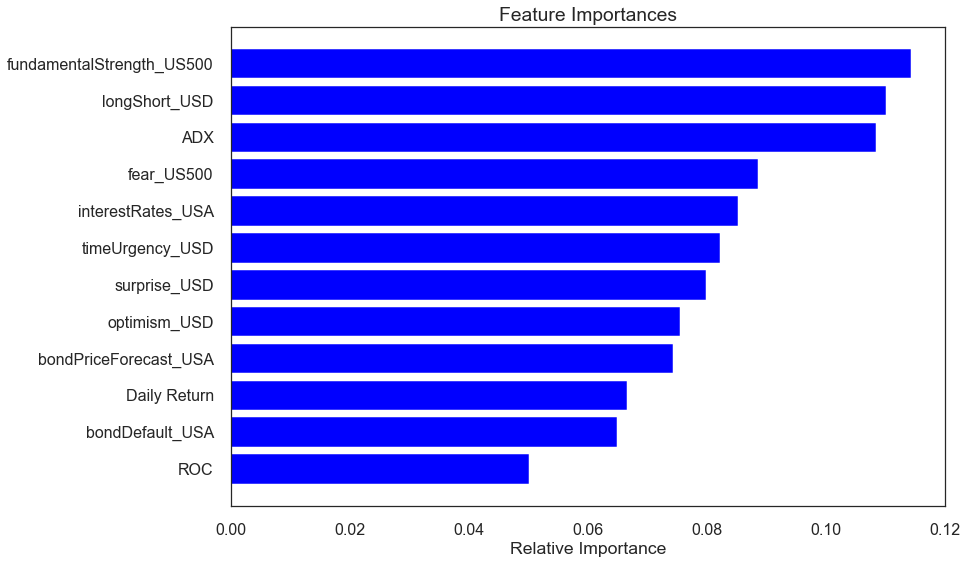

In [49]:
# applying first model for setting the side (sign) of the bet (buy or sell)
first_model, features = apply_model(train_labels, test_labels, 
                                    X_train_[features_all], X_test_[features_all], 
                                    'XGB', 'neg_log_loss', sfs=False)

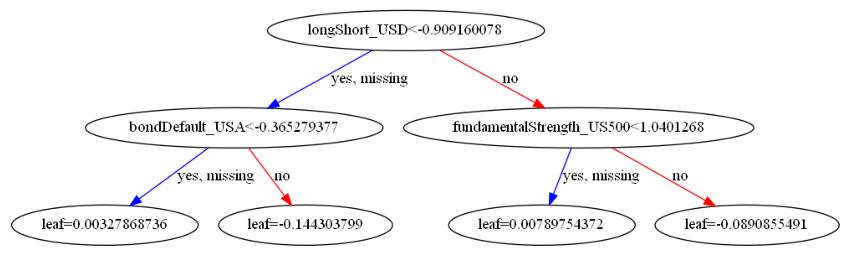

In [50]:
# only for xgb
# plotting decision trees from the model
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(first_model, num_trees=0, ax=ax); #first
#plot_tree(first_model, num_trees=1, ax=ax, rankdir='LR'); #second
#plot_tree(first_model, num_trees=2, ax=ax, rankdir='LR'); #third

In [51]:
# generating meta-labels with previous forecast
# these will be the labels for the next model
tbm_train = tbm_train.reindex(X_train_.index)
tbm_test = tbm_test.reindex(X_test_.index)

tbm_train['side'] = first_model.predict(X_train_[features_all]) # outcome of first model
tbm_test['side'] = first_model.predict(X_test_[features_all])

metalabels_train = get_bins(tbm_train, sp500_train['Adj Close'])
metalabels_test = get_bins(tbm_test, sp500_test['Adj Close'])
metalabels_train['label'] = metalabels_train.bin
metalabels_test['label'] = metalabels_test.bin
metalabels_train.dropna(inplace=True)
metalabels_test.dropna(inplace=True)

X_train_ = X_train_.reindex(metalabels_train.index)
X_test_ = X_test_.reindex(metalabels_test.index)
X_train_['side'] = metalabels_train.side
X_test_['side'] = metalabels_test.side

In [52]:
tbm_test.side.unique()

array([-1.,  1.])

In [53]:
display(metalabels_train.groupby('label').count())
display(metalabels_test.groupby('label').count())

,ret,trgt,bin,side
label,,,,
0.0,451,451,451,451
1.0,1037,1037,1037,1037


,ret,trgt,bin,side
label,,,,
0.0,128,128,128,128
1.0,127,127,127,127


In [54]:
# appending side or previous outcome to the explanatory variables of the second model
features_all.append('side')

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   35.8s finished


Train F1-score:  0.6949332686001455
Train accuracy:  0.5779569892473119
Train AUC:  0.5135903756371402
Train best score -0.68
Best parameters: {'base_score': 0.5, 'early_stopping_rounds': 5, 'eta': 5e-05, 'max_depth': 3, 'n_estimators': 40}
Accuracy: 67.84%
AUC: 0.73
Classification report:
              precision    recall  f1-score   support

         0.0       0.64      0.80      0.72       128
         1.0       0.74      0.55      0.63       127

    accuracy                           0.68       255
   macro avg       0.69      0.68      0.67       255
weighted avg       0.69      0.68      0.67       255

Confusion matrix:
[[103  25]
 [ 57  70]]


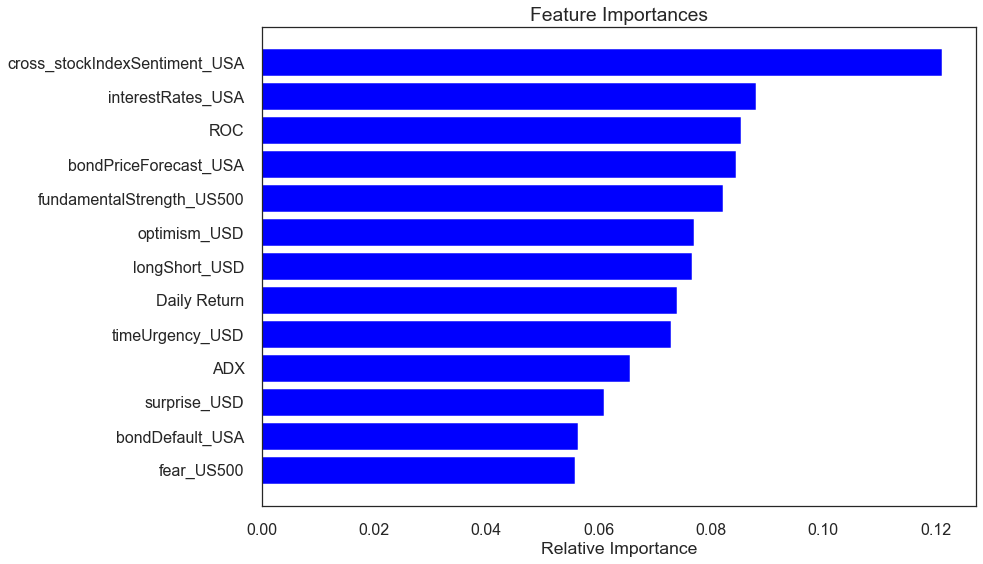

In [55]:
# training and testing second model for setting the size of the bet 
# (here, it will only tell whether to take the bet or not)
second_model, _ = apply_model(metalabels_train, metalabels_test, 
                              X_train_[features_all], X_test_[features_all], 
                              'XGB', 'neg_log_loss', sfs=False)

In [56]:
# generating final predictions
final_predictions = second_model.predict(X_test_[features_all]) * X_test_.side

In [57]:
# Let's check if we have a reasonable/profitable outcome during the first stage of the covid-19 bear market
final_predictions['2020-02-10': '2020-04-30']

2020-02-12   -0.0
2020-02-20   -0.0
2020-02-24   -0.0
2020-02-25   -0.0
2020-02-26   -0.0
2020-02-28   -0.0
2020-03-03   -1.0
2020-03-04   -0.0
2020-03-05   -1.0
2020-03-06   -0.0
2020-03-10   -0.0
2020-03-11   -1.0
2020-03-12   -0.0
2020-03-13   -1.0
2020-03-16   -1.0
2020-03-17   -1.0
2020-03-23   -0.0
2020-03-25   -1.0
2020-03-27   -1.0
2020-04-02   -0.0
2020-04-07   -1.0
2020-04-10   -0.0
2020-04-20   -0.0
2020-04-22   -1.0
2020-04-27   -0.0
2020-04-30   -0.0
Name: side, dtype: float64

In [58]:
# plotting labels to see outcome
#configure_plotly_browser_state()
figura = make_subplots(specs=[[{"secondary_y": False}]])

dataset = X_test_
dataset['Predictions'] = final_predictions
dataset['Labels'] = test_labels['label']

figura.add_trace(go.Scatter(y=X_test['Adj Close'],
                            x=X_test.index,
                            mode='lines',
                            name='SP500 Close Price'),
                 secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Labels == 1)]['Adj Close'],
               x=dataset[(dataset.Labels == 1)].index,
               mode='markers',
               name='Real Buy',
               marker=dict(size=8, color='#2DCCCD'),
               marker_symbol=19),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Labels == -1)]['Adj Close'],
               x=dataset[(dataset.Labels == -1)].index,
               mode='markers',
               name='Real Sell',
               marker=dict(size=8, color='#D8BE75'),
               marker_symbol=20),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == 0)]['Adj Close'],
               x=dataset[(dataset.Predictions == 0)].index,
               mode='markers',
               name='Predicted Do Not Take Bet',
               marker=dict(size=5, color='#bfbfbf'),
               marker_symbol=0),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == 1)]['Adj Close'],
               x=dataset[(dataset.Predictions == 1)].index,
               mode='markers',
               name='Predicted Buy',
               marker=dict(size=8, color='#008000'),
               marker_symbol=5),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == -1)]['Adj Close'],
               x=dataset[(dataset.Predictions == -1)].index,
               mode='markers',
               name='Predicted Sell',
               marker=dict(size=8, color='#FF0000'),
               marker_symbol=6),
               secondary_y=False,)

figura.update_layout(
    title_text='SP500 Index and predicted positions | Test',
    colorway = bbva)

figura.update_xaxes(rangeslider_visible=True)
figura.update_yaxes(title_text="<b>Price</b>", secondary_y=False)

figura.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        dict(font = dict(color = "black")),
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all"),
        ])
    )
)

figura.update_layout(template='plotly_white', hovermode='x')
iplot(figura)

---